In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, List, Tuple, Dict


class UKF:
    """
    Unscented Kalman Filter.

    This filter propagates mean and covariance through nonlinear functions
    using the Unscented Transform (UT).

    Equations:
      lambda = alpha^2 * (n + kappa) - n
      Wm[0] = lambda / (n + lambda)
      Wc[0] = Wm[0] + (1 - alpha^2 + beta)
      Wm[i] = Wc[i] = 1 / (2*(n + lambda)), for i = 1,...,2n

    Sigma points:
      chi_0 = x
      chi_i = x + [sqrt((n+lambda)*P)]_i
      chi_{i+n} = x - [sqrt((n+lambda)*P)]_i

    Unscented transform:
      y_mean = sum_i Wm[i] * Y_i
      P_y = sum_i Wc[i] * (Y_i - y_mean)(Y_i - y_mean)^T + noise_cov

    Cross-covariance:
      P_xz = sum_i Wc[i] * (chi_i - x)(Y_i - y_mean)^T

    Kalman gain:
      K = P_xz * P_zz^{-1}

    Update:
      x = x_pred + K * (z - z_pred)
      P = P_pred - K * P_zz * K^T
    """

    def __init__(
        self,
        f: Callable[[np.ndarray], np.ndarray],
        h: Callable[[np.ndarray], np.ndarray],
        Q: np.ndarray,
        R: np.ndarray,
        x0: np.ndarray,
        P0: np.ndarray,
        alpha: float = 1e-3,
        beta: float = 2.0,
        kappa: float = None,
        state_constraints: Optional[Callable[[np.ndarray], np.ndarray]] = None,
        zero_cross_covariance: bool = True,
    ):
        """
        Initialize UKF.

        f: state transition function x_{k+1} = f(x_k)
        h: measurement function z_k = h(x_k)
        Q: process noise covariance
        R: measurement noise covariance
        x0: initial state mean
        P0: initial state covariance
        alpha, beta, kappa: UT tuning parameters
        state_constraints: optional state constraints function
        zero_cross_covariance: optional zero-ing of cross-covariances
        """
        # Check dimensions of Q and P0 match state dimension
        assert Q.shape == (len(x0), len(x0)), "Q dimension mismatch"
        assert P0.shape == (len(x0), len(x0)), "P0 dimension mismatch"

        self.f = f
        self.h = h
        self.Q = Q.copy()
        self.R = R.copy()
        self.state_constraints = state_constraints
        self.zero_cross_covariance = zero_cross_covariance

        self.x = x0.copy()
        self.P = P0.copy()

        # Set UT parameters
        self.n = len(x0)
        self.alpha = alpha
        self.beta = beta
        self.kappa = (3 - self.n) if kappa is None else kappa

        # Compute lambda = alpha^2 * (n + kappa) - n
        self.lambda_ = self.alpha**2 * (self.n + self.kappa) - self.n

        # Number of sigma points = 2n + 1
        m = 2 * self.n + 1

        # Initialize weight vectors
        self.Wm = np.zeros(m)
        self.Wc = np.zeros(m)

        # Compute first weights:
        # Wm[0] = lambda / (n + lambda)
        # Wc[0] = Wm[0] + (1 - alpha^2 + beta)
        self.Wm[0] = self.lambda_ / (self.n + self.lambda_)
        self.Wc[0] = self.Wm[0] + (1 - self.alpha**2 + self.beta)

        # Compute remaining weights
        w = 1.0 / (2 * (self.n + self.lambda_))
        for i in range(1, m):
            self.Wm[i] = w
            self.Wc[i] = w

        # Weight consistency checks
        wm_sum = float(self.Wm.sum())
        assert abs(wm_sum - 1.0) < 1e-12, \
            f"Wm sum = {wm_sum:.3e}, but should be 1.0"
        expected_wc_sum = 1.0 + (1 - self.alpha**2 + self.beta)
        wc_sum = float(self.Wc.sum())
        assert abs(wc_sum - expected_wc_sum) < 1e-12, \
            f"Wc sum = {wc_sum:.3e}, expected {expected_wc_sum:.3e}"

        # Initialize histories for diagnostics
        self.state_history: List[np.ndarray] = [self.x.copy()]
        self.cov_history: List[np.ndarray] = [self.P.copy()]
        self.innovations: List[np.ndarray] = []
        self.innovation_covariances: List[np.ndarray] = []
        self._innovations_filt: List[np.ndarray] = []
        self._innov_cov_filt: List[np.ndarray] = []

    def _compute_sigma_points(
        self,
        x: np.ndarray,
        P: np.ndarray
    ) -> np.ndarray:
        """
        Compute sigma points for given mean x and covariance P.

        chi_0 = x
        chi_i = x + [sqrt((n+lambda)P)]_i
        chi_{i+n} = x - [sqrt((n+lambda)P)]_i
        """
        n = len(x)
        m = 2 * n + 1
        sigma_points = np.zeros((m, n))

        # Regularize covariance for numerical stability
        P_reg = P + 1e-9 * np.eye(n)
        scale = n + self.lambda_

        # Compute matrix square root of scaled covariance
        try:
            sqrt_P = np.linalg.cholesky(scale * P_reg)
        except np.linalg.LinAlgError:
            eigvals, eigvecs = np.linalg.eigh(P_reg)
            eigvals = np.maximum(eigvals, 1e-9)
            sqrt_P = eigvecs @ np.diag(np.sqrt(eigvals * scale)) @ eigvecs.T

        # Set first sigma point to mean
        sigma_points[0] = x

        # Compute offset sigma points
        for i in range(n):
            col = sqrt_P[:, i]
            sigma_points[i+1] = x + col
            sigma_points[n+i+1] = x - col

        return sigma_points

    def _unscented_transform(
        self,
        sigma_points: np.ndarray,
        transform_func: Callable[[np.ndarray], np.ndarray],
        noise_cov: Optional[np.ndarray] = None,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Apply Unscented Transform to sigma points.

        Y_i = transform_func(chi_i)
        y_mean = sum_i Wm[i] * Y_i
        P_y = sum_i Wc[i] * (Y_i - y_mean)(Y_i - y_mean)^T + noise_cov
        Returns y_mean, P_y, Y matrix.
        """
        m, _ = sigma_points.shape

        # Transform each sigma point
        Y = np.vstack([transform_func(sigma_points[i]) for i in range(m)])

        # Compute mean of transformed points
        y_mean = np.sum(self.Wm[:, None] * Y, axis=0)

        # Compute covariance of transformed points
        dim_y = Y.shape[1]
        P_y = np.zeros((dim_y, dim_y))
        for i in range(m):
            d = Y[i] - y_mean
            P_y += self.Wc[i] * np.outer(d, d)

        # Add noise covariance if provided
        if noise_cov is not None:
            P_y += noise_cov

        # Symmetrize for numerical stability
        P_y = 0.5 * (P_y + P_y.T)
        return y_mean, P_y, Y

    def predict(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Perform prediction step of UKF.

        Steps:
          1. Generate sigma points from current state.
          2. Propagate through f using UT.
          3. Add process noise.
          4. Clip final mean and inflate covariance for clipped dims.
        """
        # Generate sigma points from current state
        sigma_points = self._compute_sigma_points(self.x, self.P)

        # Propagate through state transition
        x_f, P_f, _ = self._unscented_transform(
            sigma_points,
            self.f,
            noise_cov=None,
        )

        # Add process noise
        x_pred = x_f
        P_pred = P_f + self.Q

        if self.state_constraints:
            # Clip final mean
            x_old = x_pred.copy()
            x_pred = self.state_constraints(x_pred)

            # Inflate covariance for clipped dimensions
            clipped = x_pred != x_old
            for i, was_clipped in enumerate(clipped):
                if was_clipped:
                    # Inflate variance
                    diff = x_old[i] - x_pred[i]
                    P_pred[i, i] += diff * diff

                    if self.zero_cross_covariance:
                        # Zero-out cross-covariances for dim i:
                        # Record the new variance
                        var_i = P_pred[i, i]
                        # Zero entire row and column
                        P_pred[i, :] = 0.0
                        P_pred[:, i] = 0.0
                        # Restore the inflated variance
                        P_pred[i, i] = var_i

        # Update state
        self.x = x_pred
        self.P = P_pred
        return self.x.copy(), self.P.copy()


    def update(self, z: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Perform measurement update of UKF.

        Steps:
          1. Generate sigma points from predicted mean/covariance.
          2. Propagate through h using UT.
          3. Compute cross-covariance Pxz.
          4. Compute Kalman gain and innovation.
          5. Apply unconstrained update.
          6. Clip final mean and inflate covariance for clipped dims.
          7. Ensure positive definiteness.
          8. Store histories and diagnostics.
        """
        x_pred = self.x.copy()
        P_pred = self.P.copy()

        # Generate sigma points for update
        sigma_points = self._compute_sigma_points(x_pred, P_pred)

        # Propagate through measurement function
        z_pred, Pzz, Zsigma = self._unscented_transform(
            sigma_points,
            self.h,
            noise_cov=self.R,
        )

        # Compute cross-covariance
        Pxz = np.zeros((self.n, len(z_pred)))
        for i in range(2 * self.n + 1):
            dx = sigma_points[i] - x_pred
            dz = Zsigma[i] - z_pred
            Pxz += self.Wc[i] * np.outer(dx, dz)

        # Regularize measurement covariance
        Pzz_reg = Pzz + 1e-9 * np.eye(len(z_pred))

        # Compute Kalman gain
        try:
            K = Pxz @ np.linalg.inv(Pzz_reg)
        except np.linalg.LinAlgError:
            K = Pxz @ np.linalg.pinv(Pzz_reg)

        # Compute innovation
        innov = z - z_pred

        # Unconstrained update
        x_unc = x_pred + K @ innov
        P_unc = P_pred - K @ Pzz_reg @ K.T

        # Clip final mean and inflate covariance if needed
        x_upd = x_unc
        P_upd = P_unc
        if self.state_constraints:
            # Clip final mean
            x_old = x_upd.copy()
            x_upd = self.state_constraints(x_upd)

            # Inflate covariance for clipped dimensions
            clipped = x_upd != x_old
            for i, was_clipped in enumerate(clipped):
                if was_clipped:
                    # Inflate variance
                    diff = x_old[i] - x_upd[i]
                    P_upd[i, i] += diff * diff

                    if self.zero_cross_covariance:
                        # Zero-out cross-covariances for dim i
                        var_i = P_upd[i, i]
                        P_upd[i, :] = 0.0
                        P_upd[:, i] = 0.0
                        P_upd[i, i] = var_i

        # Ensure positive definiteness
        P_upd = 0.5 * (P_upd + P_upd.T)
        eigs = np.linalg.eigvalsh(P_upd)
        if np.min(eigs) < 1e-9:
            P_upd += (1e-9 - np.min(eigs)) * np.eye(self.n)

        # Assign updated state
        self.x = x_upd
        self.P = P_upd

        # Store histories and diagnostics
        self.state_history.append(self.x.copy())
        self.cov_history.append(self.P.copy())
        self.innovations.append(innov)
        self.innovation_covariances.append(Pzz)

        # Compute filtered innovation for diagnostics
        sigma_updated = self._compute_sigma_points(self.x, self.P)
        z_f, Pzz_f, _ = self._unscented_transform(
            sigma_updated,
            self.h,
            noise_cov=self.R,
        )
        self._innovations_filt.append(z - z_f)
        self._innov_cov_filt.append(Pzz_f)

        return self.x.copy(), self.P.copy()

    def run_sequence(
        self,
        measurements: np.ndarray,
        steps_per_meas: int
    ) -> np.ndarray:
        """
        Run UKF over a sequence of measurements.

        For each measurement z_k:
          - Call predict() steps_per_meas times
          - Call update(z_k)
        Returns array of state_history excluding initial state.
        """
        for z in measurements:
            for _ in range(steps_per_meas):
                self.predict()
            self.update(z)
        return np.array(self.state_history)[1:]

    def get_nis(self, method: str = 'predicted') -> Optional[float]:
        """
        Compute average Normalized Innovation Squared (NIS).

        method: 'predicted' uses pre-update innovations,
                'filtered' uses post-update innovations.
        """
        if method == 'predicted':
            inn_list = self.innovations
            S_list = self.innovation_covariances
        elif method == 'filtered':
            inn_list = self._innovations_filt
            S_list = self._innov_cov_filt
        else:
            raise ValueError("method must be 'predicted' or 'filtered'")

        if not inn_list:
            return None

        nis_vals = []
        for inn, S in zip(inn_list, S_list):
            try:
                # NIS = innov^T S^{-1} innov
                nis = float(inn.T @ np.linalg.inv(S) @ inn)
                nis_vals.append(nis)
            except np.linalg.LinAlgError:
                continue

        return float(np.mean(nis_vals)) if nis_vals else None

In [2]:
class GolfBallPhysics:
    """
    Golf ball physics: quadratic drag plus Magnus effect plus spin decay.

    State x = [pos(3), vel(3), spin(3)]
    Equations:
      Fd = -0.5 * rho * Cd * A * |v| * v
      Fm =  0.5 * rho * Cl * A * cross(spin, v)
      a = (Fd + Fm) / m - [0,0,g]
      pos' = pos + dt * v
      vel' = vel + dt * a
      spin' = spin * (1 - decay_factor*dt)
    """

    def __init__(self, dt: float = 0.01):
        """
        Initialize physics parameters.
        dt: time step size
        """
        self.dt = dt
        self.m = 0.04593
        self.r = 0.02135
        self.A = np.pi * self.r**2
        self.g = 9.81
        self.rho = 1.225
        self.Cd = 0.25
        self.Cl = 0.2

    def state_transition(self, x: np.ndarray) -> np.ndarray:
        """
        Compute next state given current state x.
        """
        pos = x[0:3]
        vel = x[3:6]
        spin = x[6:9]

        # Compute drag: Fd = -0.5*rho*Cd*A*|v|*v
        v_mag = max(np.linalg.norm(vel), 1e-10)
        Fd = -0.5 * self.rho * self.Cd * self.A * v_mag * vel

        # Compute Magnus: Fm = 0.5*rho*Cl*A*cross(spin, vel)
        Fm = 0.5 * self.rho * self.Cl * self.A * np.cross(spin, vel)

        # Compute acceleration and apply gravity
        a = (Fd + Fm) / self.m
        a[2] -= self.g

        # Integrate position and velocity
        new_pos = pos + self.dt * vel
        new_vel = vel + self.dt * a

        # Apply spin decay
        new_spin = spin * (1.0 - 0.001 * self.dt)

        return np.hstack([new_pos, new_vel, new_spin])

In [3]:
class GolfSensorSystem:
    """
    Sensor system fusing radar and two cameras.

    Radar: [range, radial velocity]
    Camera: [azimuth, elevation] angles.
    """

    def __init__(
        self,
        radar_pos: Optional[np.ndarray] = None,
        camera_positions: Optional[List[np.ndarray]] = None,
    ):
        """
        Initialize sensor positions and noise std deviations.
        """
        # Set radar position
        self.radar_pos = (
            radar_pos
            if radar_pos is not None
            else np.array([0.0, -5.0, 2.0])
        )
        # Set camera positions
        self.camera_positions = (
            camera_positions
            if camera_positions is not None
            else [
                np.array([-10.0, -5.0, 5.0]),
                np.array([10.0, -5.0, 5.0]),
            ]
        )
        self.radar_range_std = 0.5
        self.radar_velocity_std = 0.5
        self.camera_angle_std = 0.002

    def radar_measurement(
        self,
        x: np.ndarray,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Compute radar measurement [range, radial velocity].
        """
        pos = x[0:3]
        vel = x[3:6]
        r_vec = pos - self.radar_pos
        r_mag = max(np.linalg.norm(r_vec), 1e-10)
        r_hat = r_vec / r_mag
        v_rad = float(np.dot(vel, r_hat))

        meas = np.array([r_mag, v_rad])
        if add_noise:
            meas += np.random.normal(
                loc=[0.0, 0.0],
                scale=[self.radar_range_std,
                       self.radar_velocity_std],
            )
        return meas

    def camera_measurement(
        self,
        x: np.ndarray,
        camera_idx: int = 0,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Compute camera measurement [azimuth, elevation].
        """
        pos = x[0:3]
        cam = self.camera_positions[camera_idx]
        r = pos - cam
        r_xy2 = max(r[0]**2 + r[1]**2, 1e-10)

        # Azimuth and elevation
        az = float(np.arctan2(r[1], r[0]))
        el = float(np.arctan2(r[2], np.sqrt(r_xy2)))

        meas = np.array([az, el])
        if add_noise:
            meas += np.random.normal(
                loc=0.0,
                scale=self.camera_angle_std,
                size=2,
            )
        return meas

    def fused_measurement(
        self,
        x: np.ndarray,
        add_noise: bool = True
    ) -> np.ndarray:
        """
        Fuse radar and two camera measurements into 6D vector.
        """
        return np.hstack([
            self.radar_measurement(x, add_noise),
            self.camera_measurement(x, 0, add_noise),
            self.camera_measurement(x, 1, add_noise),
        ])

    def measurement_function(
        self,
        x: np.ndarray
    ) -> np.ndarray:
        """
        Measurement function without noise for UKF update.
        """
        return self.fused_measurement(x, add_noise=False)

In [4]:
def golf_ball_constraints(x: np.ndarray) -> np.ndarray:
    """
    Enforce physical constraints:
      altitude >= 0,
      max velocity = 100 m/s,
      max spin = 300*2*pi rad/s.
    """
    y = x.copy()

    # Clip altitude to ground level
    y[2] = max(0.0, y[2])

    # Clip velocity magnitude
    v = y[3:6]
    v_norm = np.linalg.norm(v)
    if v_norm > 100.0:
        y[3:6] = v * 100.0 / v_norm

    # Clip spin magnitude
    if len(y) >= 9:
        spin = y[6:9]
        max_spin = 300 * 2 * np.pi
        s_norm = np.linalg.norm(spin)
        if s_norm > max_spin:
            y[6:9] = spin * max_spin / s_norm

    return y

In [5]:
def simulate_golf_shot(
    physics: GolfBallPhysics,
    sensors: GolfSensorSystem,
    initial_speed: float = 70,
    launch_angle: float = 12,
    backspin_rpm: float = 2500,
    sidespin_rpm: float = 300,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate 9D state trajectory and 6D noisy measurements.

    x0 = [pos_x,pos_y,pos_z,vx,vy,vz,spin_x,spin_y,spin_z]
    """
    theta = np.deg2rad(launch_angle)
    back = backspin_rpm * 2 * np.pi / 60
    side = sidespin_rpm * 2 * np.pi / 60
    vx = initial_speed * np.cos(theta)
    vz = initial_speed * np.sin(theta)

    x0 = np.array([
        0.0, 0.0, 0.1,
        vx,  0.0, vz,
        side, -back, 0.0,
    ])
    traj: List[np.ndarray] = [x0.copy()]
    meas: List[np.ndarray] = []

    dt_meas = 0.05
    t = 0.0
    max_t = 10.0

    # Simulate until ground impact or max time
    while traj[-1][2] >= 0 and t < max_t:
        for _ in range(int(dt_meas / physics.dt)):
            traj.append(physics.state_transition(traj[-1]))
        if traj[-1][2] >= 0:
            meas.append(sensors.fused_measurement(traj[-1], add_noise=True))
        t += dt_meas

    return np.array(traj), np.array(meas)

In [6]:
def rmse(a: np.ndarray, b: np.ndarray) -> float:
    """
    Compute root mean square error between arrays a and b.
    """
    return float(np.sqrt(np.mean((a - b)**2)))


def position_rmse(truth: np.ndarray, est: np.ndarray) -> float:
    """
    Compute RMSE for position components.
    """
    return rmse(truth[:, :3], est[:, :3])


def velocity_rmse(truth: np.ndarray, est: np.ndarray) -> float:
    """
    Compute RMSE for velocity components.
    """
    return rmse(truth[:, 3:6], est[:, 3:6])


def spin_error(true_rpm: np.ndarray, est_rpm: np.ndarray) -> float:
    """
    Compute mean absolute error for spin (RPM).
    """
    return float(np.mean(np.abs(true_rpm - est_rpm)))


def landing_error(t: np.ndarray, e: np.ndarray) -> float:
    """
    Compute 2D landing error between true t and estimated e.
    """
    return float(np.linalg.norm(t[:2] - e[:2]))

In [7]:
def plot_trajectory(
    true_traj: np.ndarray,
    est_trajs: List[np.ndarray],
    labels: List[str],
    sample: int = 5,
    title: Optional[str] = None,
) -> None:
    """
    Plot 3D trajectory of true and estimated states.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    idx = slice(0, None, sample)

    ax.plot(
        true_traj[idx, 0],
        true_traj[idx, 1],
        true_traj[idx, 2],
        '--k',
        lw=3,
        label=labels[0]
    )
    colors = ['b', 'r', 'g', 'm', 'c']

    for i, (traj, lbl) in enumerate(zip(est_trajs, labels[1:])):
        ax.plot(
            traj[idx, 0],
            traj[idx, 1],
            traj[idx, 2],
            '-',
            color=colors[i],
            lw=2,
            marker='o',
            markevery=10,
            markersize=4,
            alpha=0.8,
            label=lbl
        )

    ax.set(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)')
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_error(
    t: np.ndarray,
    errors: List[np.ndarray],
    labels: List[str],
    ylabel: str,
    title: Optional[str] = None,
    logscale: bool = False,
) -> None:
    """
    Plot error metrics over time.
    """
    plt.figure(figsize=(8, 5))
    for err, lbl in zip(errors, labels):
        if logscale:
            plt.semilogy(t, err, lw=2, label=lbl)
        else:
            plt.plot(t, err, lw=2, label=lbl)
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_sigma_points_analysis(
    filter_: UKF,
    n_snapshots: int = 5
) -> None:
    """
    Plot sigma point spread analysis for UKF state dims 0,1,2.
    """
    indices = np.linspace(
        0,
        len(filter_.state_history) - 1,
        n_snapshots,
        dtype=int
    )

    fig, axes = plt.subplots(3, 1, figsize=(8, 8))
    labels = ['X', 'Y', 'Z']

    for ax, label, idx in zip(axes, labels, range(3)):
        positions = [filter_.state_history[i][idx] for i in indices]
        stds = []
        for i in indices:
            var = filter_.cov_history[i][idx, idx]
            stds.append(np.sqrt(max(var, 0)))
        ax.errorbar(
            range(n_snapshots),
            positions,
            yerr=3 * np.array(stds),
            fmt='o-',
            capsize=5,
            capthick=2
        )
        ax.set_ylabel(f'{label} Position (m)')
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Snapshot Index')
    fig.suptitle('UKF State Uncertainty Evolution (3sigma bounds)')
    plt.tight_layout()
    plt.show()

In [10]:
def plot_innovation_analysis(
    innovations: List[np.ndarray],
    covariances: List[np.ndarray],
) -> None:
    """
    Plot innovation values with 3sigma covariance bounds.
    """
    inn = np.vstack(innovations)
    n_meas = inn.shape[1]
    fig, axes = plt.subplots(n_meas, 1, figsize=(8, 2 * n_meas))
    names = ['Range', 'RadVel', 'Az1', 'El1', 'Az2', 'El2']

    for i, ax in enumerate(axes):
        ax.plot(inn[:, i], '-b', lw=1)
        sigma3 = 3 * np.sqrt([C[i, i] for C in covariances])
        ax.fill_between(range(len(inn)), -sigma3, sigma3, alpha=0.2)
        ax.set_ylabel(names[i])
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Update #')
    fig.suptitle('Innovation Analysis')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [11]:
class BallTrackingDemo:
    """
    Orchestrates simulation, UKF filtering, metrics, and plotting
    for a golf ball ballistic tracking demo.
    """

    def __init__(
        self,
        physics: GolfBallPhysics,
        sensors: GolfSensorSystem,
        initial_speed: float = 70,
        launch_angle: float = 12,
        backspin_rpm: float = 2500,
        sidespin_rpm: float = 300,
        dt_meas: float = 0.05,
    ):
        """
        Initialize demo parameters.
        """
        self.physics = physics
        self.sensors = sensors
        self.initial_speed = initial_speed
        self.launch_angle = launch_angle
        self.backspin_rpm = backspin_rpm
        self.sidespin_rpm = sidespin_rpm
        self.dt_meas = dt_meas

    def run(self) -> None:
        """
        Run simulation, filtering, compute metrics, and plotting.
        """
        # Simulate trajectory and measurements
        traj, meas = simulate_golf_shot(
            self.physics,
            self.sensors,
            self.initial_speed,
            self.launch_angle,
            self.backspin_rpm,
            self.sidespin_rpm,
        )
        print(f"Simulated {len(traj)} states, {len(meas)} measurements")

        # Initialize filter with guessed initial state and covariances
        x0_true = traj[0]
        x0_guess = x0_true.copy()
        x0_guess[3:6] *= 0.9
        x0_guess[6:9] = [0, -1000 * 2 * np.pi / 60, 0]

        P0 = np.diag([1.0] * 3 + [10] * 3 + [50] * 3)
        Q = np.diag([0.01] * 3 + [0.1] * 3 + [1.0] * 3)
        R = np.diag([
            self.sensors.radar_range_std**2,
            self.sensors.radar_velocity_std**2,
            *(
                self.sensors.camera_angle_std**2
                for _ in range(4)
            ),
        ])

        # Create UKF instance
        filter_ = UKF(
            f=self.physics.state_transition,
            h=self.sensors.measurement_function,
            Q=Q,
            R=R,
            x0=x0_guess,
            P0=P0,
            alpha=0.01,
            beta=2.0,
            kappa=0,
            state_constraints=golf_ball_constraints,
        )

        # Compute steps per measurement
        steps = int(self.dt_meas / self.physics.dt)

        # Run filter sequence
        est_states = filter_.run_sequence(meas, steps)

        # Align truth and estimates
        truth_meas = traj[steps::steps]
        n = min(len(truth_meas), len(est_states))
        truth = truth_meas[:n]
        est = est_states[:n]
        time = np.arange(n) * self.dt_meas

        # Compute performance metrics
        pos_err = position_rmse(truth, est)
        vel_err = velocity_rmse(truth, est)
        true_spin = -truth[:, 7] * 60 / (2 * np.pi)
        est_spin = -est[:, 7] * 60 / (2 * np.pi)
        spin_err_val = spin_error(true_spin, est_spin)

        t_idx = np.where(truth[:, 2] <= 0)[0]
        e_idx = np.where(est[:, 2] <= 0)[0]
        land_err = (
            landing_error(truth[t_idx[0]], est[e_idx[0]])
            if t_idx.size and e_idx.size else None
        )

        nis_pred = filter_.get_nis('predicted')
        nis_filt = filter_.get_nis('filtered')

        # Print performance metrics
        print("\n=== Performance Metrics ===")
        print(f"Position RMSE  : {pos_err:.3f} m")
        print(f"Velocity RMSE  : {vel_err:.3f} m/s")
        print(f"Backspin MAE   : {spin_err_val:.0f} RPM")
        if land_err is not None:
            print(f"Landing Error  : {land_err:.2f} m")
        print(
            f"UKF Parameters: "
            f"alpha={filter_.alpha}, "
            f"beta={filter_.beta}, "
            f"kappa={filter_.kappa}"
        )
        if nis_pred is not None:
            print(f"NIS (predicted): {nis_pred:.2f}")
        if nis_filt is not None:
            print(f"NIS (filtered) : {nis_filt:.2f}\n")

        # Generate plots
        plot_trajectory(
            truth,
            [est],
            ['True', 'UKF'],
            sample=10,
            title='Golf Ball Trajectory - UKF',
        )
        plot_error(
            time,
            [np.linalg.norm(truth[:, :3] - est[:, :3], axis=1)],
            ['Pos Error'],
            ylabel='Error (m)',
            title='Position Error - UKF'
        )
        plot_error(
            time,
            [true_spin, est_spin],
            ['True', 'Est'],
            ylabel='Backspin (RPM)',
            title='Backspin Estimation - UKF'
        )
        plot_sigma_points_analysis(filter_)
        plot_innovation_analysis(
            filter_.innovations,
            filter_.innovation_covariances,
        )
        plot_innovation_analysis(
            filter_._innovations_filt,
            filter_._innov_cov_filt,
        )

Simulated 1001 states, 200 measurements

=== Performance Metrics ===
Position RMSE  : 0.131 m
Velocity RMSE  : 1.737 m/s
Backspin MAE   : 514 RPM
UKF Parameters: alpha=0.01, beta=2.0, kappa=0
NIS (predicted): 3.88
NIS (filtered) : 2.22



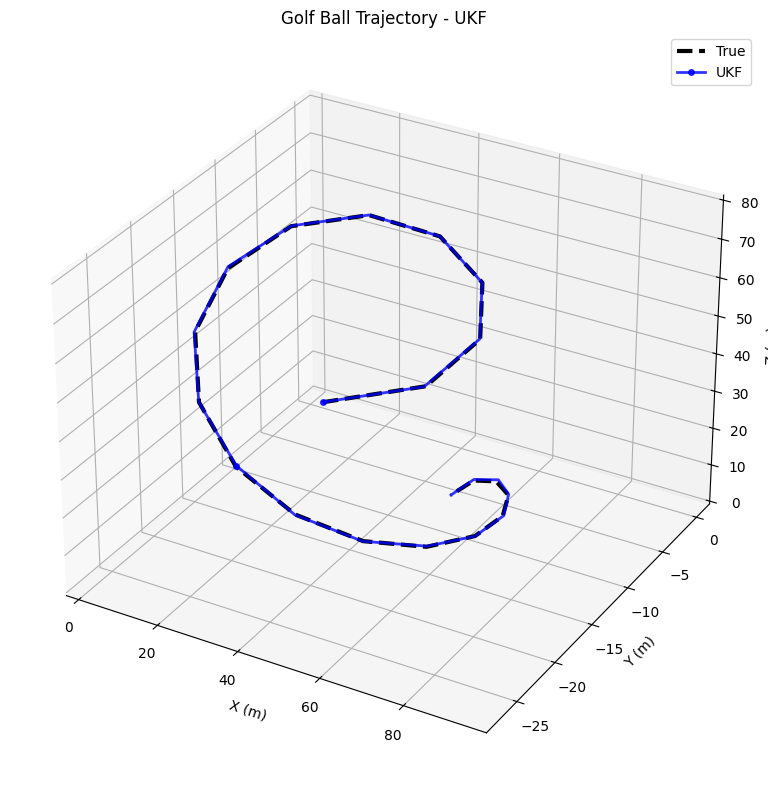

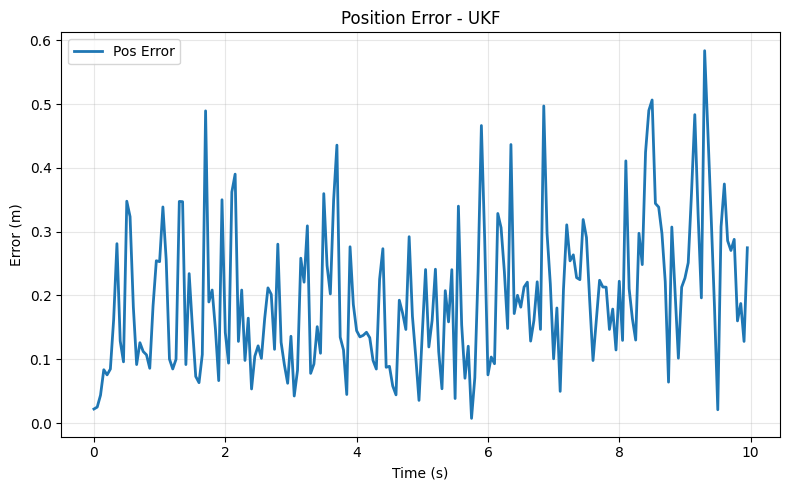

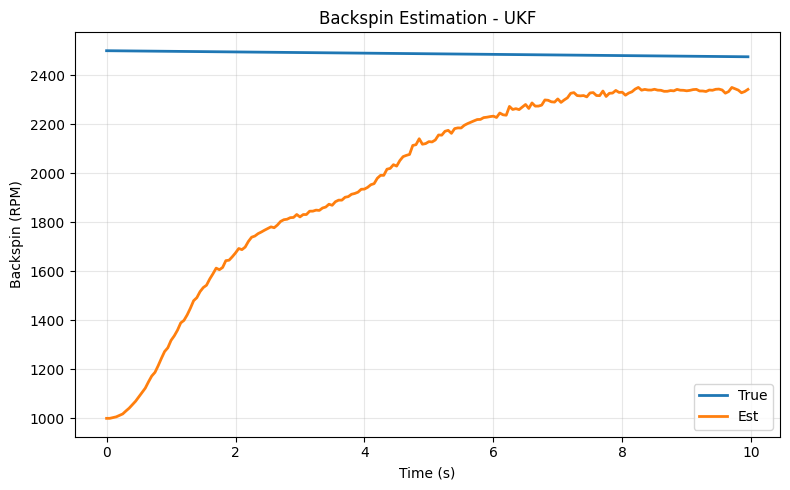

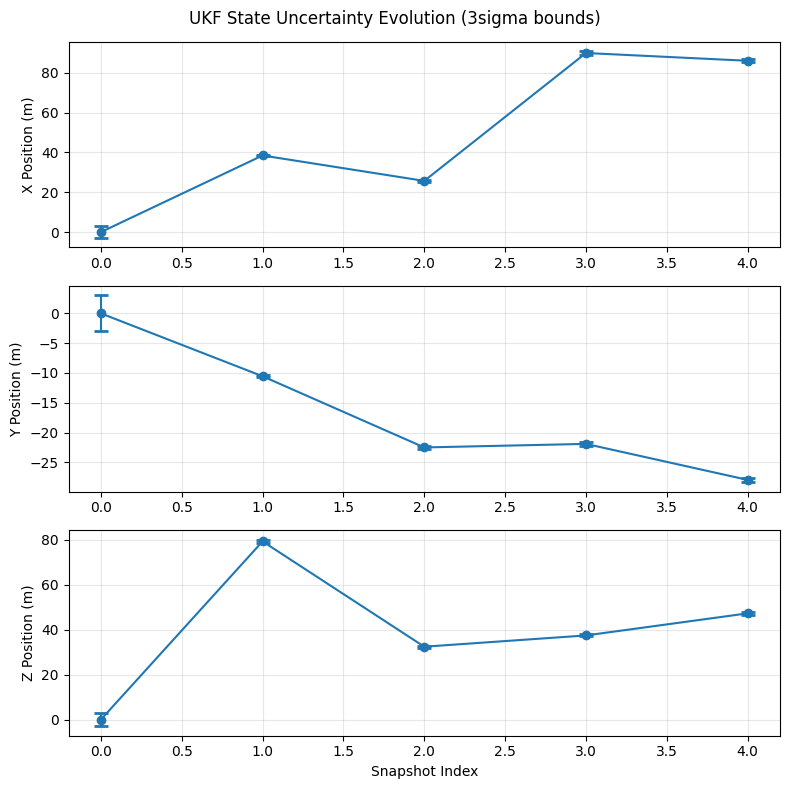

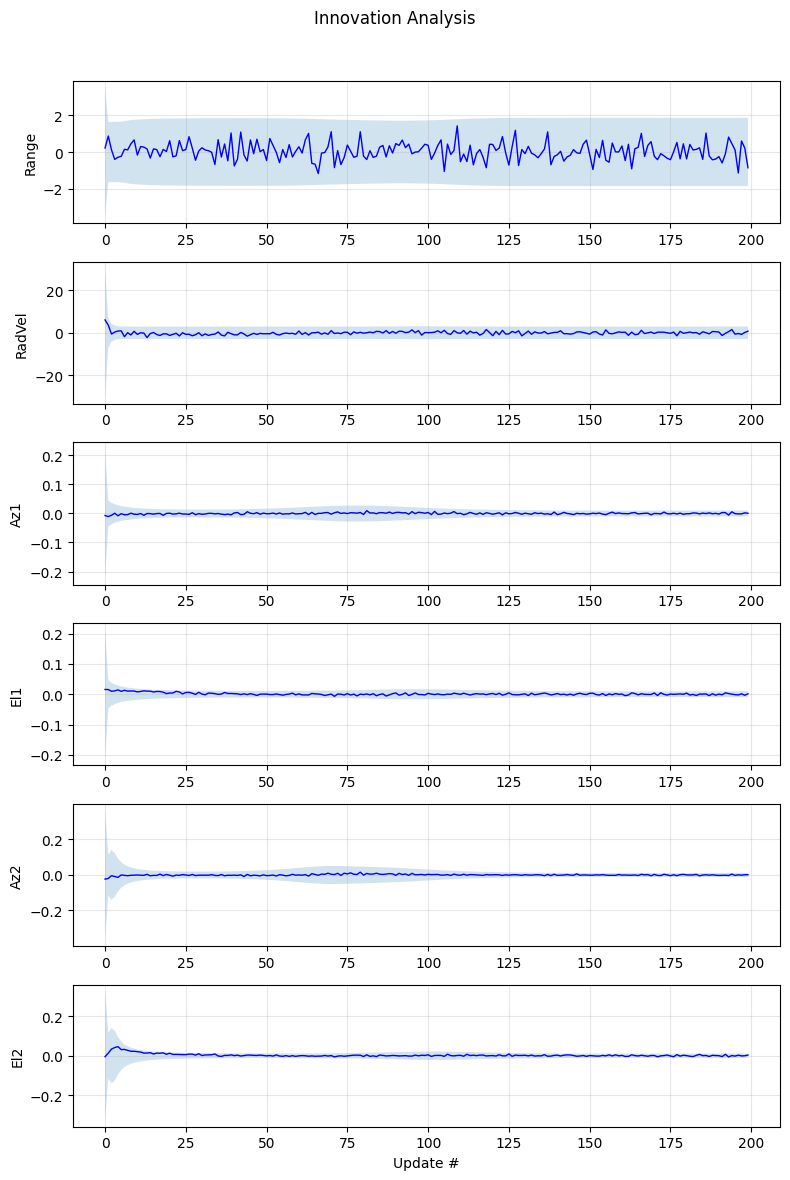

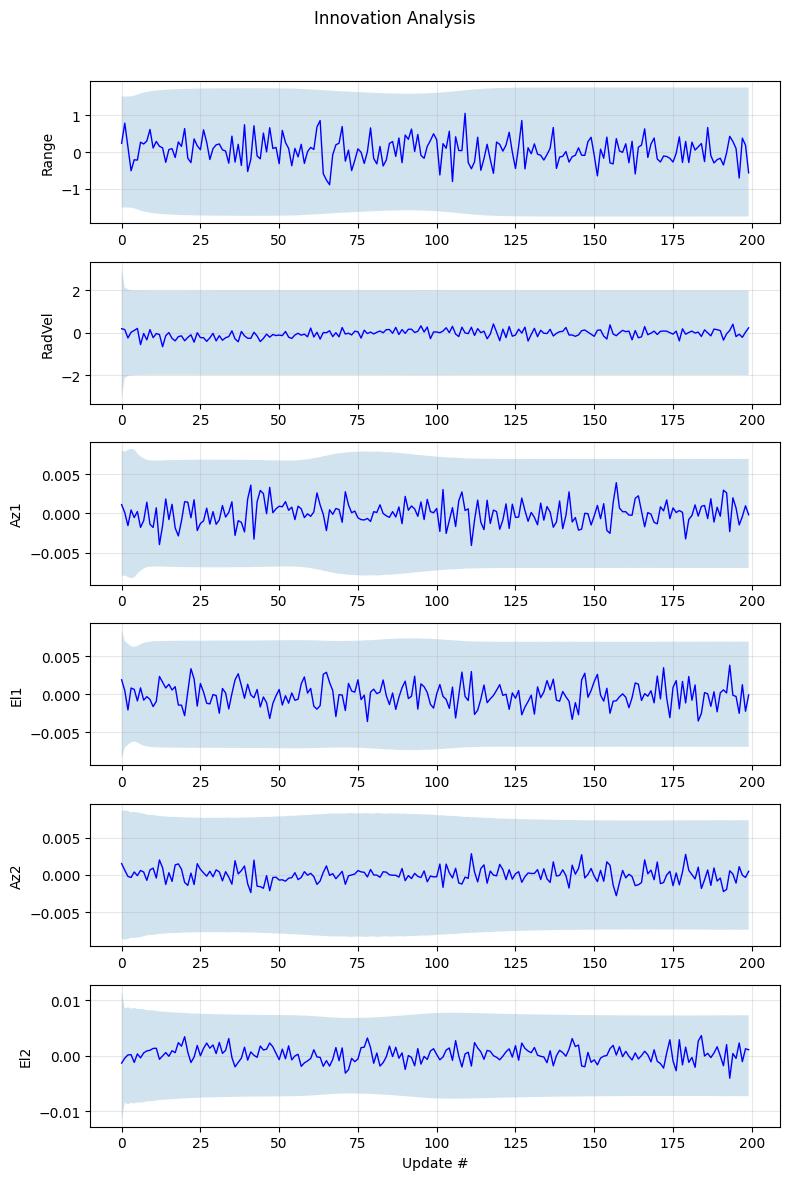

In [12]:
def main() -> None:
    """
    Main entry point for ball tracking demo.
    """
    np.random.seed(42)
    demo = BallTrackingDemo(
        physics=GolfBallPhysics(dt=0.01),
        sensors=GolfSensorSystem(),
        initial_speed=70,
        launch_angle=12,
        backspin_rpm=2500,
        sidespin_rpm=300,
        dt_meas=0.05,
    )
    demo.run()


if __name__ == "__main__":
    main()